# Dots & focal enrichment

Welcome to the dot calling notebook!

Punctate pairwise peaks of enriched contact frequency are a prevalent feature of mammalian interphase contact maps. These features are also referred to as ‘dots’ or ‘loops’ in the literature, and can appear either in isolation or as parts of grids and at the corners of domains.

HiCCUPS, proposed in [Rao et al. 2014](https://doi.org/10.1016/j.cell.2014.11.021), is a common approach for calling dots in contact maps. HICCUPS uses a multi-step procedure to score and return a filtered list of extracted dots. Scoring is done by convolving a set of ***kernels*** with the contact map. However, since HICCUPS is written in Java it is challenging to modify the parameters used at specific steps of the calling procedure, which can be important for calling dots at new resolutions or in new organismal or cellular contexts.

*Cooltools* implements a similar approach for calling dots in Python. This enables users to easily vary the parameters and processing steps used for different Hi-C or Micro-C datasets.

In [1]:
import pandas as pd
import numpy as np
from itertools import chain

# Hi-C utilities imports: 
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag
from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorials rely on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

# Visualization imports: 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.ticker import EngFormatter

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

## Load data and define a genomic view

To call dots, we need an input cooler file with Hi-C data, and regions for calculation of expected (e.g. chromosomes or chromosome arms).

In [2]:
# Download the test data from osf and define cooler:
data_dir = './data/'
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir=data_dir)
# 10 kb is a resolution at which one can clearly see "dots":
binsize = 10_000
# Open cool file with Micro-C data:
clr = cooler.Cooler(f'{data_dir}/test.mcool::/resolutions/{binsize}')

In [3]:
# define genomic view that will be used to call dots and pre-compute expected

# Use bioframe to fetch the genomic features.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler. 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()

# intra-arm expected
expected = cooltools.expected_cis(
    clr,
    view_df=hg38_arms,
    nproc=4,
)

## Dot-calling with default parameters

We first call dots with default parameters (i.e. similar to HiCCUPs). Later we illustrate the various parameters than can be easily modified in *cooltools*.

Here is a brief description of the steps involved in *cooltools* `dots()`:

- A set of convolution ***kernels*** are recommended based on the resolution of `clr`, if user-defined convolution kernels are not provided (i.e. `kernels=None`). 

- The requested portion of the heatmap (defined by `view_df` and `max_loci_separation`) is split into smaller ***tiles*** of size `tile_size`. This ensures the entire heatmap is not loaded into memory at once, and computationally intensive steps can be done in parallel using `nproc` workers. `tile_size` and `nproc` do not affect the outcome of the procedure.

- Tiles of the heatmap are convolved with the provided kernels to calculate localy adjusted expected for each pixel. This is in turn used to calculate p-values, assuming a Poisson distribution of pixel counts.

- Pixels are assigned to geometrically-spaced "lambda-bins" of locally-adjusted expected for statistical testing. Within each lambda-bin, signficantly enriched pixels are "caled" using [BH-FDR](https://en.wikipedia.org/wiki/False_discovery_rate) multiple hypothesis testing procedure, and thresholds of significance are calculated for each lambda-bin and each kernel-type (controlled by `lambda_bin_fdr`).

- Significantly-enriched pixels are extracted, based on the thresholds in each lambda bin. Note the *cooltools* implementation of this step involves a second pass with the same convolution kernels to re-score pixels, as this is less costly than storing all such scores in memory.

- Additional clustering and empirical filtering is optionally performed (depending on `clustering_radius` and `cluster_filtering`). 

See the [`dotfinder` docstring](https://github.com/open2c/cooltools/blob/master/cooltools/api/dotfinder.py) for additional practical details of the implementation.



In [4]:
dots_df = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 29.498 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 186 tiles to extract enriched pixels
INFO:root:creating a Pool of 4 workers to tackle 186 tile

### Visualizing dot-calling with the default parameters
To visualize the results of this dot calling, we overlay small rectangles at the positions of the called dots over the HiC map.

In [5]:
# create a functions that would return a series of rectangles around called dots
# in a specific region, and exposing importnat plotting parameters
def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none"):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = e1 - s1
        width2 = e2 - s2
        if loc == "upper":
            yield patches.Rectangle((s2, s1), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((s1, s2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

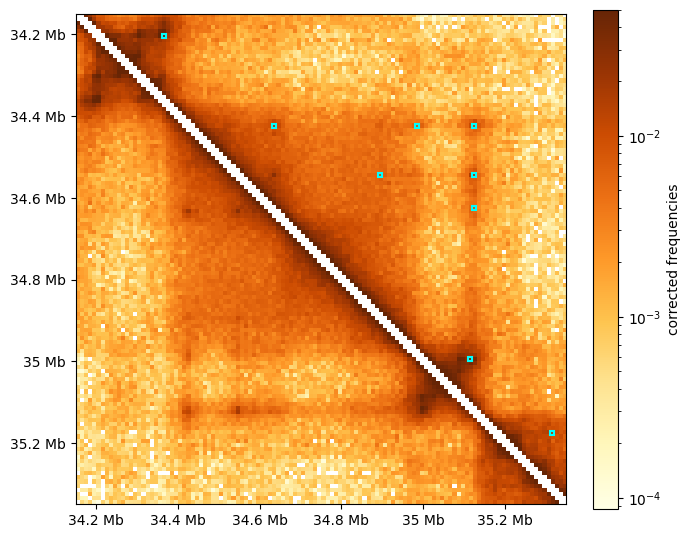

In [6]:
# define a region to look into as an example
start = 34_150_000
end = start + 1_200_000
region = ('chr17', start, end)

# heatmap kwargs
matshow_kwargs = dict(
    cmap='YlOrBr',
    norm=LogNorm(vmax=0.05),
    extent=(start, end, end, start)
)

# colorbar kwargs
colorbar_kwargs = dict(fraction=0.046, label='corrected frequencies')

# compute heatmap for the region
region_matrix = clr.matrix(balance=True).fetch(region)
for diag in [-1,0,1]:
    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow( region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df, region, lw=1.5):
    ax.add_patch(box)


## Skipping clustering and cluster enrichment filtering

Dot-calling returns pixels that are enriched relative to some local background. Such pixels often come in groups ("clusters"). By default `dots()` picks a single representative for each cluster (i.e. centroid). However, *cooltools* users can easily turn clustering off for debugging or alternative clustering approaches:

In [7]:
dots_df_all = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    max_loci_separation=10_000_000,
    clustering_radius=None,  # None - implies no clustering
    cluster_filtering=False,  # ignored when clustering is off
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 25.523 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 186 tiles to extract enriched pixels
INFO:root:creating a Pool of 4 workers to tackle 186 tile

The visualization below compares clustered dots (cyan) with all enriched pixels before clustering (blue)

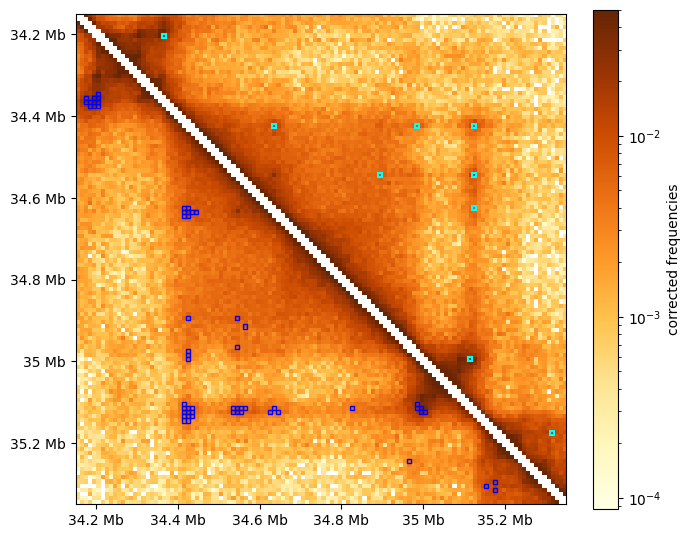

In [8]:
f, ax = plt.subplots(figsize=(7,7))
# draw heatmap
im = ax.matshow(region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in chain(
        rectangles_around_dots(dots_df, region, lw=1.5),  # clustered & filtered
        rectangles_around_dots(dots_df_all, region, loc="lower", ec="blue"),  # unclustered
    ):
    ax.add_patch(rect)

## Convolution kernels and local expected

A useful local background  to calculate the enrichment of pixels was defined in [Rao et al. 2014](https://doi.org/10.1016/j.cell.2014.11.021) as a "donut"-shaped surrounding of a given pixel between ~20 to ~50 kb away from that pixel.

Such a local surrounding is best thought of in the terms of convolutional kernels e.g. as in [image processing](https://en.wikipedia.org/wiki/Kernel_(image_processing)). In this framework, calcluating the local background for all pixels is simply obtained as the convolution of a contact map with the "donut"-shaped kernel. 

Additional kernels can be used to downweight unwanted enrichment types. In addition to the "donut" kernel, the default kernels recommended in cooltools `dots()` are:
 - "vertical" to avoid calling pixels that are part of vertical stripes as dots
 - "horizontal" to avoid calling pixels that are part of horizontal stripes as dots
 - "lowleft" to avoid calling pixels at the corners of domains as dots
 
These four kernels are illustrated below, where pixels that are included in the calculations are highlighted in yellow, the pixel of interest is highlighted in red, and pixels that are not included in the local background are in purple. A checkerboard pattern is overlayed on the figure to emphasize individual pixels.

In [9]:
# function to draw kernels:
def draw_kernel(kernel, axis=None, cmap='viridis'):
    if axis is None:
        f, axis = plt.subplots()
    # kernel:
    imk = axis.imshow(
                    kernel[::-1,::-1],  # flip it, as in convolution
                    alpha=0.85,
                    cmap=cmap,
                    interpolation='nearest')
    # draw a square around the target pixel:
    x0 = kernel.shape[0] // 2 - 0.5
    y0 = kernel.shape[1] // 2 - 0.5
    rect = patches.Rectangle((x0, y0), 1, 1, lw=1, ec='r', fc='r')
    axis.add_patch(rect)

    # clean axis:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels('',visible=False)
    axis.set_yticklabels('',visible=False)
    axis.set_title("{} kernel".format(ktype),fontsize=16)
    # add a checkerboard to highlight pixels:
    checkerboard = np.add.outer(range(kernel.shape[0]),
                                range(kernel.shape[1])) % 2
    # show it:
    axis.imshow(checkerboard,
            cmap='gray',
            interpolation='nearest',
            alpha=0.3)

    return imk

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000


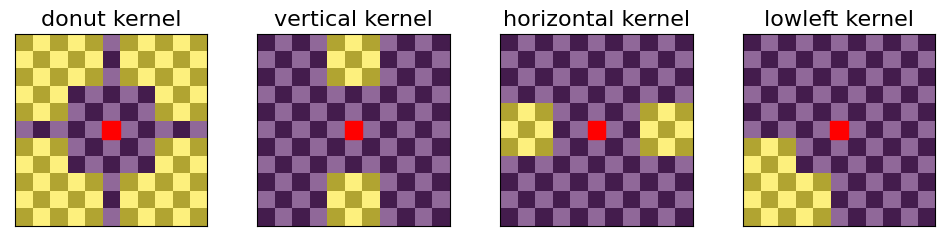

In [10]:
kernels = cooltools.api.dotfinder.recommend_kernels(binsize)

fig, axs = plt.subplots(ncols=4, figsize=(12,2.5))
for ax, (ktype, kernel) in zip(axs, kernels.items()):
    imk = draw_kernel(kernel, ax)

### Calling dots with a "rounded donut" kernel

*Cooltools* enables experimentation and modification of kernels used for determining local enrichment scores. Here we show the result for replacing the default "donut" kernel with a "rounded donut". 

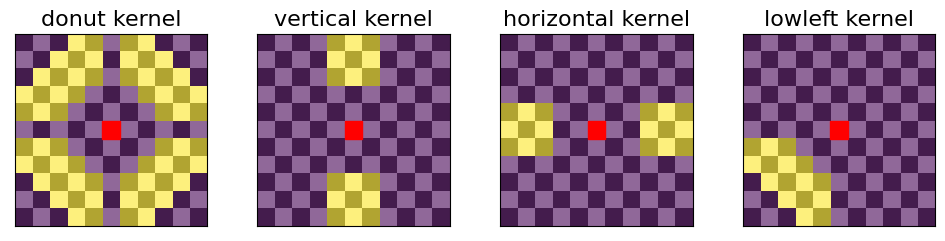

In [11]:
# create a grid of coordinates from -5 to 5, to define round kernels
# see https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html for details
half = 5  # half width of the kernel
x, y = np.meshgrid(
    np.linspace(-half, half, 2*half + 1),
    np.linspace(-half, half, 2*half + 1),
)
# now define a donut-like mask as pixels between 2 radii: sqrt(7) and sqrt(30):
mask = (x**2+y**2 > 7) & (x**2+y**2 <= 30)
mask[:,half] = 0
mask[half,:] = 0

# lowleft mask - zero out neccessary parts
mask_ll = mask.copy()
mask_ll[:,:half] = 0
mask_ll[half:,:] = 0

# new kernels with more round donut and lowleft masks:
kernels_round = {'donut': mask,
 'vertical': kernels["vertical"].copy(),
 'horizontal': kernels["horizontal"].copy(),
 'lowleft': mask_ll}

# plot rounded kernels
fig, axs = plt.subplots(ncols=4, figsize=(12,2.5))
for ax, (ktype, kernel) in zip(axs, kernels_round.items()):
    imk = draw_kernel(kernel, ax)

In [12]:
#### call dots using redefined kernels (without clustering) 

dots_round_df_all = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    kernels=kernels_round, # provide custom kernels
    max_loci_separation=10_000_000,
    clustering_radius=None,
    nproc=4,
)

/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.9/site-packages/cooltools/api/dotfinder.py:1571: UserWarning: Compatibility checks for 'kernels' are not fully implemented yet, use at your own risk
  warnings.warn(
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 33.029 sec ...
INFO:root:Determined threshold

The visualization below compares dots called using "rounded" kernels (cyan) with the dots called using recommended kernels (blue). As one can tell the results are similar, yet the "rounded" kernels allow for calling dots closer to the diagonal because of the shape of the kernel.

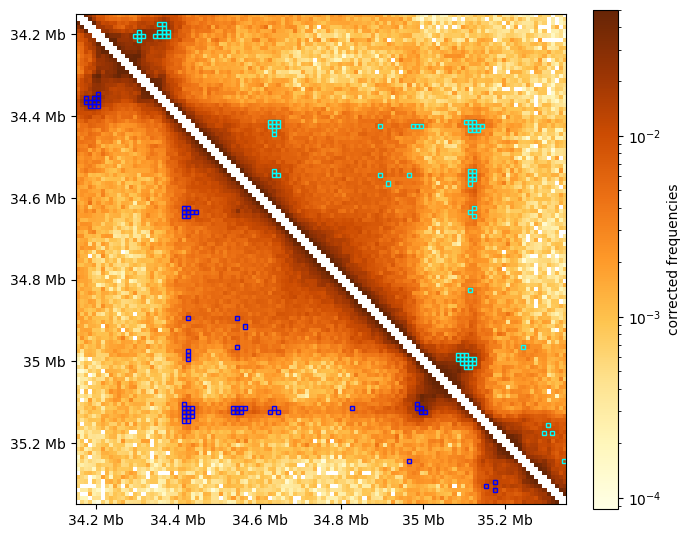

In [13]:
f, ax = plt.subplots(figsize=(7,7))
# draw heatmap
im = ax.matshow(region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in chain(
        rectangles_around_dots(dots_round_df_all, region),
        rectangles_around_dots(dots_df_all, region, loc="lower", ec="blue"),
    ):
    ax.add_patch(rect)

In [14]:
# TODO CTCF-based analysis to look